# 무비렌즈 데이터를 가지고 사용자 협업 필터링을 구현해보자

surprise 모듈을 설치

In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1634022 sha256=7e5f15485197a333dbc5f9998c9a892eb71b6f673ab0b6752eab67fb883cb876
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# 데이터 로딩 및 분석

In [3]:
from surprise import Dataset
from surprise import Reader

from collections import defaultdict
import numpy as np
import pandas as pd


In [4]:
movies = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/movies.csv")
ratings = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv")

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
movie_ratings = pd.merge(movies, ratings, left_on='movieId', right_on='movieId')

In [8]:
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


In [9]:
movies.shape # 9125개의 영화

(9125, 3)

In [10]:
ratings.shape # 십만개가 넘는 평점들

(100004, 4)

데이터 분석
- 영화별 평점수: min, max, median, mean
- 가장 평점이 많은 영화 10개는?
- 영화별 평점 평균: min, max, median, mean
- 가장 평점이 높은 영화 10개는? (100개 이상 평점이 있는 영화 중)

In [11]:
movie_ratings["movieId"].nunique() # 60개 정도가 빔(9125-9066). 평점이 없는 영화가 60개 정도 된다는 소리임. 

9066

In [12]:
movie_ratings_summary = movie_ratings[["movieId", "rating"]].groupby(["movieId"]).agg(["count", "median", "mean"]) # movieId와 rating만 남겨놓고, 이 데이터를 movieId로 그룹화한 다음에(그러면 rating만 남음), 그리고 rating을 count 해보고, 중간값을 보고, 평균값을 본다. 

In [13]:
movie_ratings_summary.head()

rating                 
         count median      mean
movieId                        
1          247    4.0  3.872470
2          107    3.0  3.401869
3           59    3.0  3.161017
4           13    3.0  2.384615
5           56    3.0  3.267857

In [14]:
movie_ratings_summary.columns

MultiIndex([('rating',  'count'),
            ('rating', 'median'),
            ('rating',   'mean')],
           )

In [15]:
movie_ratings_summary.columns = ["count", "median", "mean"] # 열을 간단하게 바꿈

In [16]:
movie_ratings_summary.columns # 바꾼 결과 [14] 셀(위에 위에 있는 셀)과 비교해봐라 

Index(['count', 'median', 'mean'], dtype='object')

In [17]:
movie_ratings_summary.sort_values("count", ascending=False).head(10) # count 값을 기준으로, 내림차순으로 sorting 한 후, 상위 10개 추출

,count,median,mean
movieId,,,
356,341,4.0,4.054252
296,324,4.5,4.256173
318,311,5.0,4.487138
593,304,4.0,4.138158
260,291,4.5,4.221649
480,274,4.0,3.706204
2571,259,4.5,4.183398
1,247,4.0,3.872470
527,244,4.5,4.303279


In [18]:
movie_ratings_summary.sort_values("mean", ascending=False).head(10) # mean 값을 기준으로, 내림차순으로 sorting 한 후, 상위 10개 추출

,count,median,mean
movieId,,,
163949,1,5.0,5.0
71180,1,5.0,5.0
51471,1,5.0,5.0
52617,1,5.0,5.0
53887,1,5.0,5.0
54251,1,5.0,5.0
54328,1,5.0,5.0
55555,1,5.0,5.0
56869,1,5.0,5.0


In [19]:
movie_ratings_summary[movie_ratings_summary["count"]>100].sort_values("mean", ascending=False).head(10) # 평점을 100개 이상 받은 영화들 중, 평점의 평균이 높은 것 10개 추출

,count,median,mean
movieId,,,
858,200,5.00,4.487500
318,311,5.00,4.487138
1221,135,5.00,4.385185
50,201,4.50,4.370647
527,244,4.50,4.303279
1193,144,4.50,4.256944
608,224,4.50,4.256696
296,324,4.50,4.256173
2858,220,4.25,4.236364


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


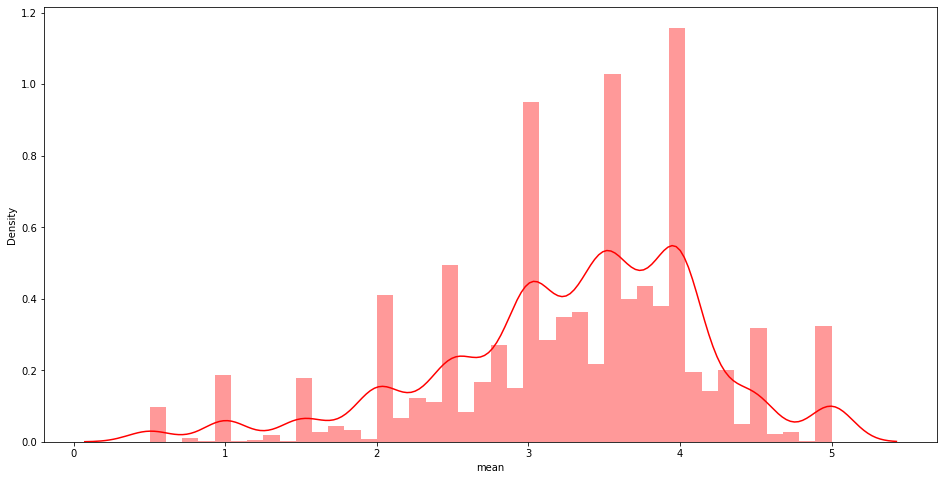

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.distplot(a=movie_ratings_summary['mean'], kde=True, color='r')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


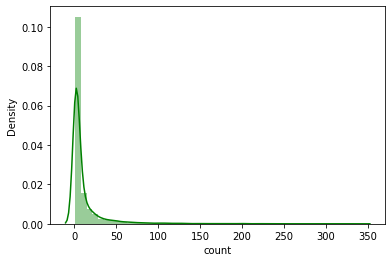

In [26]:
# 평점의 수 
sns.distplot(a=movie_ratings_summary['count'], color = 'g')
# 평점을 하나 받은 영화가 대다수임.

In [27]:
movie_ratings["userId"].nunique() # 사용자 수(id 수니까)

671

In [28]:
user_rating_summary = movie_ratings[["userId","rating"]].groupby(["userId"]).agg(["count", "median", "mean"]) # userId, rating 데이터만 남기고, 이를 userId로 그룹화 한 후, rating 데이터의 수, 중간 값, 평균을 알아보자

In [29]:
user_rating_summary.head()
# userId 1은 박한 사람
# userId 4는 후한 사람

rating                 
        count median      mean
userId                        
1          20    2.5  2.550000
2          76    3.0  3.486842
3          51    3.5  3.568627
4         204    5.0  4.348039
5         100    4.0  3.910000

In [30]:
user_rating_summary.columns = ["count", "median", "mean"]

In [31]:
user_rating_summary.sort_values("count", ascending=False).head(10) # count 기준으로 내림차순 정렬 후, 상위 10개 추출
# userId 547은 2391개나 평점을 주었다.

,count,median,mean
userId,,,
547,2391,3.5,3.366792
564,1868,4.0,3.552463
624,1735,3.0,2.894236
15,1700,3.0,2.621765
73,1610,3.5,3.374224
452,1340,3.0,3.189179
468,1291,3.0,2.965918
380,1063,3.5,3.366416
311,1019,3.0,3.006379


In [32]:
user_rating_summary.sort_values("median", ascending=False).head(10) # median 기준으로 내림차순 정렬 후, 상위 10개 추출
# 평점을 후하게 준 사람들

,count,median,mean
userId,,,
230,94,5.0,4.473404
432,62,5.0,4.411290
622,31,5.0,4.725806
499,33,5.0,4.272727
145,38,5.0,4.500000
559,129,5.0,4.418605
473,76,5.0,4.315789
28,50,5.0,4.280000
556,25,5.0,4.400000


In [33]:
user_rating_summary.sort_values("median", ascending=True).head(10) # median 기준으로 오름차순 정렬 후, 하위 10개 추출
# 평점을 박하게 준 사람들

,count,median,mean
userId,,,
207,46,0.50,1.804348
581,49,0.50,1.459184
579,21,0.50,1.333333
609,140,1.00,1.985714
429,27,2.00,2.240741
315,55,2.00,2.454545
325,20,2.00,2.525000
35,20,2.25,2.400000
79,55,2.50,2.518182


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


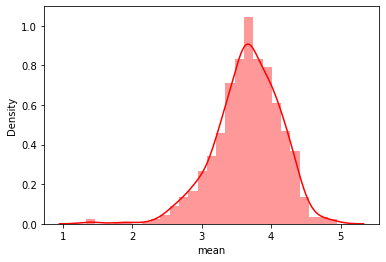

In [34]:
sns.distplot(a=user_rating_summary["mean"], kde=True, color='r')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


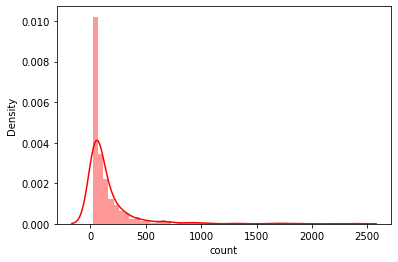

In [35]:
sns.distplot(a=user_rating_summary["count"], kde=True, color='r')
# 대부분 사용자들이 많은 평점을 주진 않는다.

In [36]:
def getMovieName(movie_ratings, movieID):
  return movie_ratings[movie_ratings["movieId"] == movieID][["title", "genres"]].values[0]

def getMovieID(movie_ratings, movieName):
  return movie_ratings[movie_ratings["title"] == movieName][["movieId", "genres"]].values[0]

# 영화 데이터를 surprise 모듈을 통해 로딩

In [37]:
!wget "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv" # wget으로 로컬로 다운로드 받을 수 있음

--2022-09-01 11:31:41--  https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv
Resolving grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)... 52.219.146.15
Connecting to grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)|52.219.146.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2438266 (2.3M) [text/csv]
Saving to: ‘ratings.csv’

ratings.csv         100%[===================>]   2.33M  2.47MB/s    in 0.9s    

2022-09-01 11:31:42 (2.47 MB/s) - ‘ratings.csv’ saved [2438266/2438266]



In [38]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1) # , 로 구분(seperate)됨
data = Dataset.load_from_file("ratings.csv", reader=reader)

In [52]:
from surprise import KNNBasic
import heapq
from collections import defaultdict # 딕셔너리 문제 해결(?)


In [40]:
trainSet = data.build_full_trainset() # build_full_trainset 으로 호출하게 되면 지금 로딩 된 것들을 모두 다 training set으로 쓰게 된다.

In [53]:
sim_options = {
    'name': 'cosine',
    'user_based': True # 유저 기반
}

model = KNNBasic(sim_options=sim_options) # KNN 사용
model.fit(trainSet)
simsMatrix = model.compute_similarities() # 사용자들끼리 비교된 유사도 행렬이 simsMatrix로 들어감

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [42]:
testUser = '85' # 기준
k = 10

# 주어진 사용자와 가장 흡사한 사용자 N을 찾는다
# 먼저 이를 Surprise 내부 ID로 변환
testUserInnerID = trainSet.to_inner_uid(testUser) # trainSet.to_inner_uid(testUser): 내부 아이디로 85를 받음
print(testUserInnerID)
# 이 사용자에 해당하는 레코드를 읽어온다
similarityRow = simsMatrix[testUserInnerID]
# 내부 아이디로는 84

84


In [43]:
# users에 모든 사용자들을 일련번호와 유사도를 갖는 튜플의 형태로 저장
# 이 때 본인은 제외
users = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID): # 아이디를 일련번호로 받고, 이 일련번호가 내부번호와 다르다면 (즉, 본인은 제외한다는 소리!)
        users.append( (innerID, score) ) # users에 모든 사용자들을 일련번호와 유사도를 갖는 튜플의 형태로 저장

In [44]:
# 이제 users 리트스에서 유사도 값을 기준으로 가장 큰 k개를 찾는다
kNeighbors = heapq.nlargest(k, users, key=lambda t: t[1]) # score 값을 기준으로 가장 큰 거부터 k개 가져와라 

In [45]:
kNeighbors
# (a,b)에서 a가 사용자 아이디(innerID), b가 유사도

[(10, 1.0),
 (11, 1.0),
 (13, 1.0),
 (24, 1.0),
 (36, 1.0),
 (44, 1.0),
 (45, 1.0),
 (51, 1.0),
 (53, 1.0),
 (61, 1.0)]

In [46]:
# 이제 유사 사용자들을 하나씩 보면서 그들이 평가한 아이템들별로 원 사용자와 유사 사용자간의 유사도를 가중치로 준 평점을 누적한다

# candidates에는 아이템별로 점수를 누적한다. 유사사용자(u')의 평점 * 사용자(u)와 유사 사용자(u')의 유사도
candidates = defaultdict(float)

# 이 K명의 최고 유사 사용자를 한명씩 루프를 돌면서 살펴본다
for similarUser in kNeighbors:
    # similarUser는 앞서 enumerate로 만든 그 포맷임 - (내부ID, 유사도값)
    innerID = similarUser[0] # 유저 아이디
    userSimilarityScore = similarUser[1] # 유사도

    # innerID에 해당하는 사용자의 아이템과 평점 정보를 읽어온다.
    # theirRatings는 (아이템ID, 평점)의 리스트임
    theirRatings = trainSet.ur[innerID] # innerID를 사용하는 사용자가 rating한 모든 아이템 정보를 theirRatings에 넣음. 
    # innerID가 평가한 모든 아이템 리스트를 하나씩 보면서 
    # 아이템ID별로 평점 정보를 합산하되 사용자와의 유사도값을 가중치로 준다
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1]) * userSimilarityScore

In [47]:
# 사용자가 이미 평가한 아이템들을 제거할 사전을 만든다
watched = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    watched[itemID] = 1

In [48]:
# 앞서 candidates에서 합산된 스코어를 기준으로 내림차순으로 소팅한 후
# 사용자(u)가 아직 못본 아이템인 경우 추천한다
# 사용자 기반 협업 필터링!!!!!
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=lambda k: k[1], reverse=True): 
    if not itemID in watched:
        movieID = trainSet.to_raw_iid(itemID)
        print(movieID, getMovieName(movie_ratings, int(movieID)), ratingSum)
        pos += 1
        if (pos > 10):
            break

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0


In [49]:
def recommendForUser(userID):
    testUserInnerID = trainSet.to_inner_uid(userID)
    similarityRow = simsMatrix[testUserInnerID]

    users = []
    for innerID, score in enumerate(similarityRow):
        if (innerID != testUserInnerID):
            users.append( (innerID, score) )

    kNeighbors = heapq.nlargest(k, users, key=lambda t: t[1])

    candidates = defaultdict(float)
    for similarUser in kNeighbors:
        innerID = similarUser[0]
        userSimilarityScore = similarUser[1]
        theirRatings = trainSet.ur[innerID]
        for rating in theirRatings:
            candidates[rating[0]] += (rating[1]) * userSimilarityScore

    watched = {}
    for itemID, rating in trainSet.ur[testUserInnerID]:
        watched[itemID] = 1

    pos = 0
    for itemID, ratingSum in sorted(candidates.items(), key=lambda k: k[1], reverse=True):
        if not itemID in watched:
            movieID = trainSet.to_raw_iid(itemID)
            print(movieID, getMovieName(movie_ratings, int(movieID)), ratingSum)
            pos += 1
            if (pos > 10):
                break

In [50]:
recommendForUser('85') #위의 결과와 동일하다. 

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0
